In [121]:
import numpy as np
import numpy.linalg as algl
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
import io
from urllib.request import urlopen

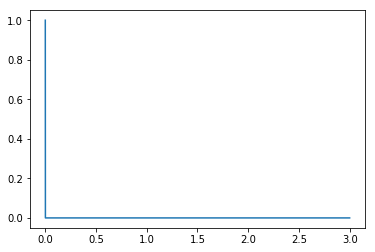

In [50]:
SR = 48000
tempo = np.arange(0, 3, 1/SR)
cantora = np.zeros(len(tempo))
ouvinte = np.zeros(len(tempo))
#palma ideal (Delta de dirac)
cantora[0] = 1.
plt.plot(tempo, cantora)
plt.show()

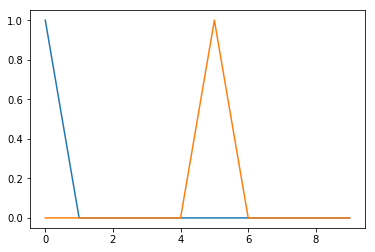

In [51]:
M = 5
Linha_de_Atraso = np.zeros(M)

for i in range(len(cantora)):
    
    ouvinte[i] = Linha_de_Atraso[i%M] # i é ponteiro de escrita
    Linha_de_Atraso[i%M] = cantora[i]
    
    
plt.plot(cantora[0:10])    
plt.plot(ouvinte[0:10])
plt.show()

In [52]:
def linhaDeAtraso(valor, Buffer, pos):
    
    M = len(Buffer)
    
    output = Buffer[pos%M] 
    Buffer[pos%M] = valor
    
    return output

In [53]:
def computaLinhaDeAtraso(cantora, M):
    
    ouvinte = np.zeros(len(cantora))

#     M = 48000
    DL = np.zeros(M)
    for i in range(len(cantora)):

        ouvinte[i] = linhaDeAtraso(cantora[i], DL, i)
    
    plt.plot(cantora)
    plt.plot(ouvinte)
    
    return ouvinte

array([0., 0., 0., ..., 0., 0., 0.])

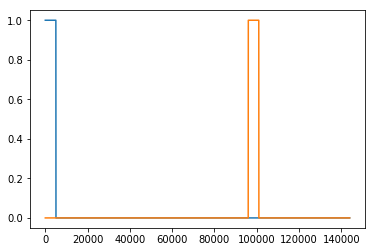

In [54]:
SR = 48000
tempo = np.arange(0, 3, 1/SR)
cantora = np.zeros(len(tempo))
cantora[0:5000] = 1.

M = 2*48000


computaLinhaDeAtraso(cantora, M)

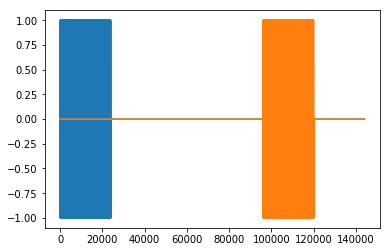

In [59]:
cantorasenoidal = np.zeros(len(tempo))
cantorasenoidal[0:SR//2] = np.sin(2*np.pi*440*tempo[0:SR//2])
M = 2*48000


ouvintesenoidal = computaLinhaDeAtraso(cantorasenoidal, M)

ipd.Audio(ouvintesenoidal+cantorasenoidal, rate=SR)

In [93]:
def linhaDeAtrasoMultipla(valor, Buffer, wpos, rpos):
    
    M = len(Buffer)
    
    output = Buffer[rpos%M] 
    Buffer[wpos%M] = valor
    
    return np.sum(output)

In [94]:
def computaLinhaDeAtrasoMultipla(cantora, M_max, M):
    
    ouvinte = np.zeros(len(cantora))

    
    DL = np.zeros(M_max)
    
    for i in range(len(cantora)):

        ouvinte[i] = linhaDeAtrasoMultipla(cantora[i], DL, i, i-M)
    
    plt.plot(cantora)
    plt.plot(ouvinte)
    
    return ouvinte

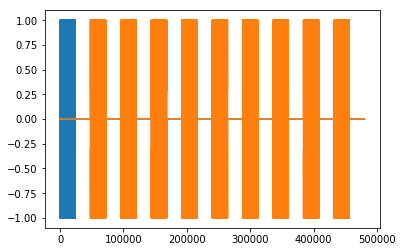

In [95]:
SR = 48000
dur = 10
tempo = np.arange(0, dur, 1/SR)

cantorasenoidal = np.zeros(len(tempo))
cantorasenoidal[0:SR//2] = np.sin(2*np.pi*440*tempo[0:SR//2])
M_max = dur*SR
M = np.arange(SR, dur*SR, SR)

ouvintesenoidal = computaLinhaDeAtrasoMultipla(cantorasenoidal, 
                                               M_max, M)

ipd.Audio(ouvintesenoidal+cantorasenoidal, rate=SR)

In [74]:
array1 = np.arange(50)

print(array1[[0, 5, 45]])

[ 0  5 45]


In [87]:
def linhaDeAtrasoInterpolada(valor, Buffer, wpos, rpos, n):
    
    M = len(Buffer)
    
    output = (1-n)*Buffer[(rpos-1)%M] + (n)*Buffer[rpos%M]
    Buffer[wpos%M] = valor
    
    return np.sum(output)

In [99]:
def computaLinhaDeAtrasoInterpolada(cantora, M_max, M):
    
    ouvinte = np.zeros(len(cantora))

    
    DL = np.zeros(M_max)
    
    M_parte_inteira = int(M)
    M_parte_decimal = M%1
    
    for i in range(len(cantora)):

        ouvinte[i] = linhaDeAtrasoInterpolada(cantora[i], DL, i,
                                              i-M_parte_inteira, M_parte_decimal)
    
    
    
    return ouvinte

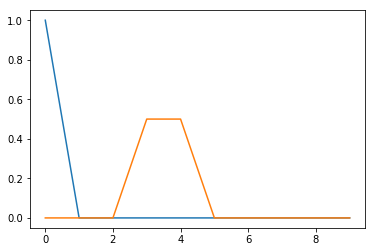

In [100]:
SR = 48000
dur = 10
tempo = np.arange(0, dur, 1/SR)

cantoradelta = np.zeros(len(tempo))
cantoradelta[0] = 1.
# cantorasenoidal[0:SR//2] = np.sin(2*np.pi*440*tempo[0:SR//2])
M_max = dur*SR
M = 3.5

ouvintedelta = computaLinhaDeAtrasoInterpolada(cantoradelta, 
                                               M_max, M)
plt.plot(cantoradelta[0:10])
plt.plot(ouvintedelta[0:10])
ipd.Audio((ouvintedelta+cantoradelta), rate=SR)

In [101]:
def linhaDeAtrasoDinamica(valor, Buffer, wpos, rpos, n):
    
    M = len(Buffer)
    
    output = (1-n)*Buffer[(rpos-1)%M] + (n)*Buffer[rpos%M]
    Buffer[wpos%M] = valor
    
    return np.sum(output)

In [104]:
def computaLinhaDeAtrasoDinamica(cantora, M_max, M, vel):
    
    ouvinte = np.zeros(len(cantora))
    c = 343
    
    DL = np.zeros(M_max)
    
    for i in range(len(cantora)):

        ouvinte[i] = linhaDeAtrasoInterpolada(cantora[i],
                                              DL, i, 
                                              i-int(M), 
                                              M%1)
        M -= vel[i]
    
    
    
    return ouvinte

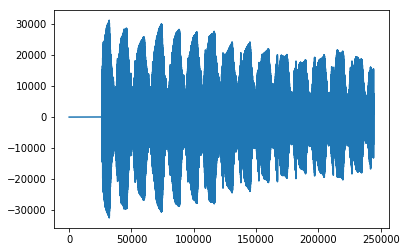

In [141]:
SR = 48000
dur = 10
tempo = np.arange(0, dur, 1/SR)
url="http://s1download-universal-soundbank.com/wav/2499.wav"


rate, ambulancia = read(io.BytesIO(urlopen(url).read()))


# cantoradinamica = np.zeros(len(tempo))

# cantoradinamica = np.sin(2*np.pi*440*tempo)

cantoradinamica = ambulancia[:, 0]
Vel = np.zeros(len(tempo))
# Vel[2*SR:5*SR] = 0.3
Vel[SR//2:5*SR//2] = 0.03
Vel[5*SR//2:5*SR//2+50000] = np.linspace(0.03, -0.03, 50000)
Vel[5*SR//2+50000:] = -0.03


M_max = dur*SR
M = SR//2

ouvintedinamica = computaLinhaDeAtrasoDinamica(cantoradinamica, 
                                               M_max, M, Vel)
#plt.plot(cantoradinamica)
plt.plot(ouvintedinamica)
ipd.Audio(ouvintedinamica, rate=SR)

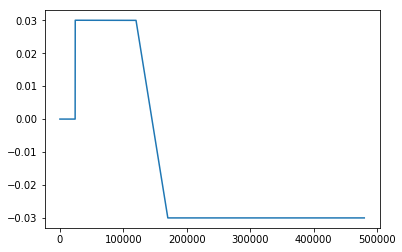

In [142]:
plt.plot(Vel)